<a href="https://colab.research.google.com/github/nikyan/spark_customer_churn/blob/master/sparkify_process_mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process Mining

- Process mining is a data mining technique that allows analysis of processes. The goal is to benchmark process against ideal or expected processes in an organization and identify deviations, best practices to drive efficency. In this Notebook, I will apply process mining algorithms to the event log data from sparkify dataset (mini) to visualize various pages accessed by the user.

- Visual examination can help in better understanding the features and may even help in feature selection by identifying highly correlated features. Also, in this Notebook I will demonstrate the use of PM4Py library on Spark Dataframe.

References:
- For more details regarding the PM4Py library, visit: https://pm4py.fit.fraunhofer.de/documentation#discovery
- https://github.com/jihoonyang92/pm4pyspark-source



## Import Libraries

In [0]:
# setup spark dependencies on Google Colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.hoobly.com/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# setup env variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
# instantiate a spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
# instal PM4Py library for process mining.
!pip install pm4py

In [90]:
# import libraries
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import *
from pyspark.sql.types import *

import pm4py
print(pm4py.__version__)

from pm4py.objects.log import log as log_instance
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.conversion.log.versions import to_event_log

from pm4py.algo.discovery.inductive import algorithm as inductive_miner

from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.petrinet import visualizer as pn_visualizer

from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.objects.conversion.dfg import converter as dfg_mining

1.3.2


## Load data

Load Spark Dataframe.

In [0]:
# link to dataset
path = "/content/drive/My Drive/ML data/mini_sparkify_event_data.json"

# read json
df = spark.read.json(path)
    
# remove empty string from userId
df = df.filter(df.userId != "")

Create a subset of Spark dataframe.

In [0]:
# subset the dataframe
df = df.select("userId", "ts", "sessionId", "page")

In [0]:
# rename columns to match pmp4y naming notation.
df = df.withColumnRenamed("userId","case:userId") \
       .withColumnRenamed("sessionId", "case") \
       .withColumnRenamed("ts", "time:timestamp") \
       .withColumnRenamed("page", "concept:name")

# order by timestamp
df = df.orderBy('ts')

In [69]:
df.show()

+-----------+--------------+----+---------------+
|case:userId|time:timestamp|case|   concept:name|
+-----------+--------------+----+---------------+
|         30| 1538352117000|  29|       NextSong|
|          9| 1538352180000|   8|       NextSong|
|         30| 1538352394000|  29|       NextSong|
|          9| 1538352416000|   8|       NextSong|
|         30| 1538352676000|  29|       NextSong|
|          9| 1538352678000|   8|       NextSong|
|          9| 1538352886000|   8|       NextSong|
|         30| 1538352899000|  29|       NextSong|
|         30| 1538352905000|  29|Add to Playlist|
|         30| 1538353084000|  29|       NextSong|
|          9| 1538353146000|   8|       NextSong|
|          9| 1538353150000|   8|    Roll Advert|
|         30| 1538353218000|  29|       NextSong|
|          9| 1538353375000|   8|       NextSong|
|          9| 1538353376000|   8|      Thumbs Up|
|         30| 1538353441000|  29|       NextSong|
|          9| 1538353576000|   8|       NextSong|


In order to use Spark dataframe, first step is to convert dataframe into PM4Py EventStream and then covert EventStream to PM4Py EventLog.

In [0]:
# convert dataframe to rdd and map each row to form dictionary
rdd = df.rdd.map(lambda row: row.asDict())

# create EventStream object
event_stream = rdd.collect()
event_stream = log_instance.EventStream(event_stream)

# convert event_stream to event_log
log = to_event_log.transform_event_stream_to_event_log(event_stream, case_glue='case')

In [0]:
# specify the case identifier key which in this case is userId.
parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case'}
# create an event log object.
event_log = log_converter.apply(log, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)

## Apply Process Mining Algorithms

### Directly-Follows Graph

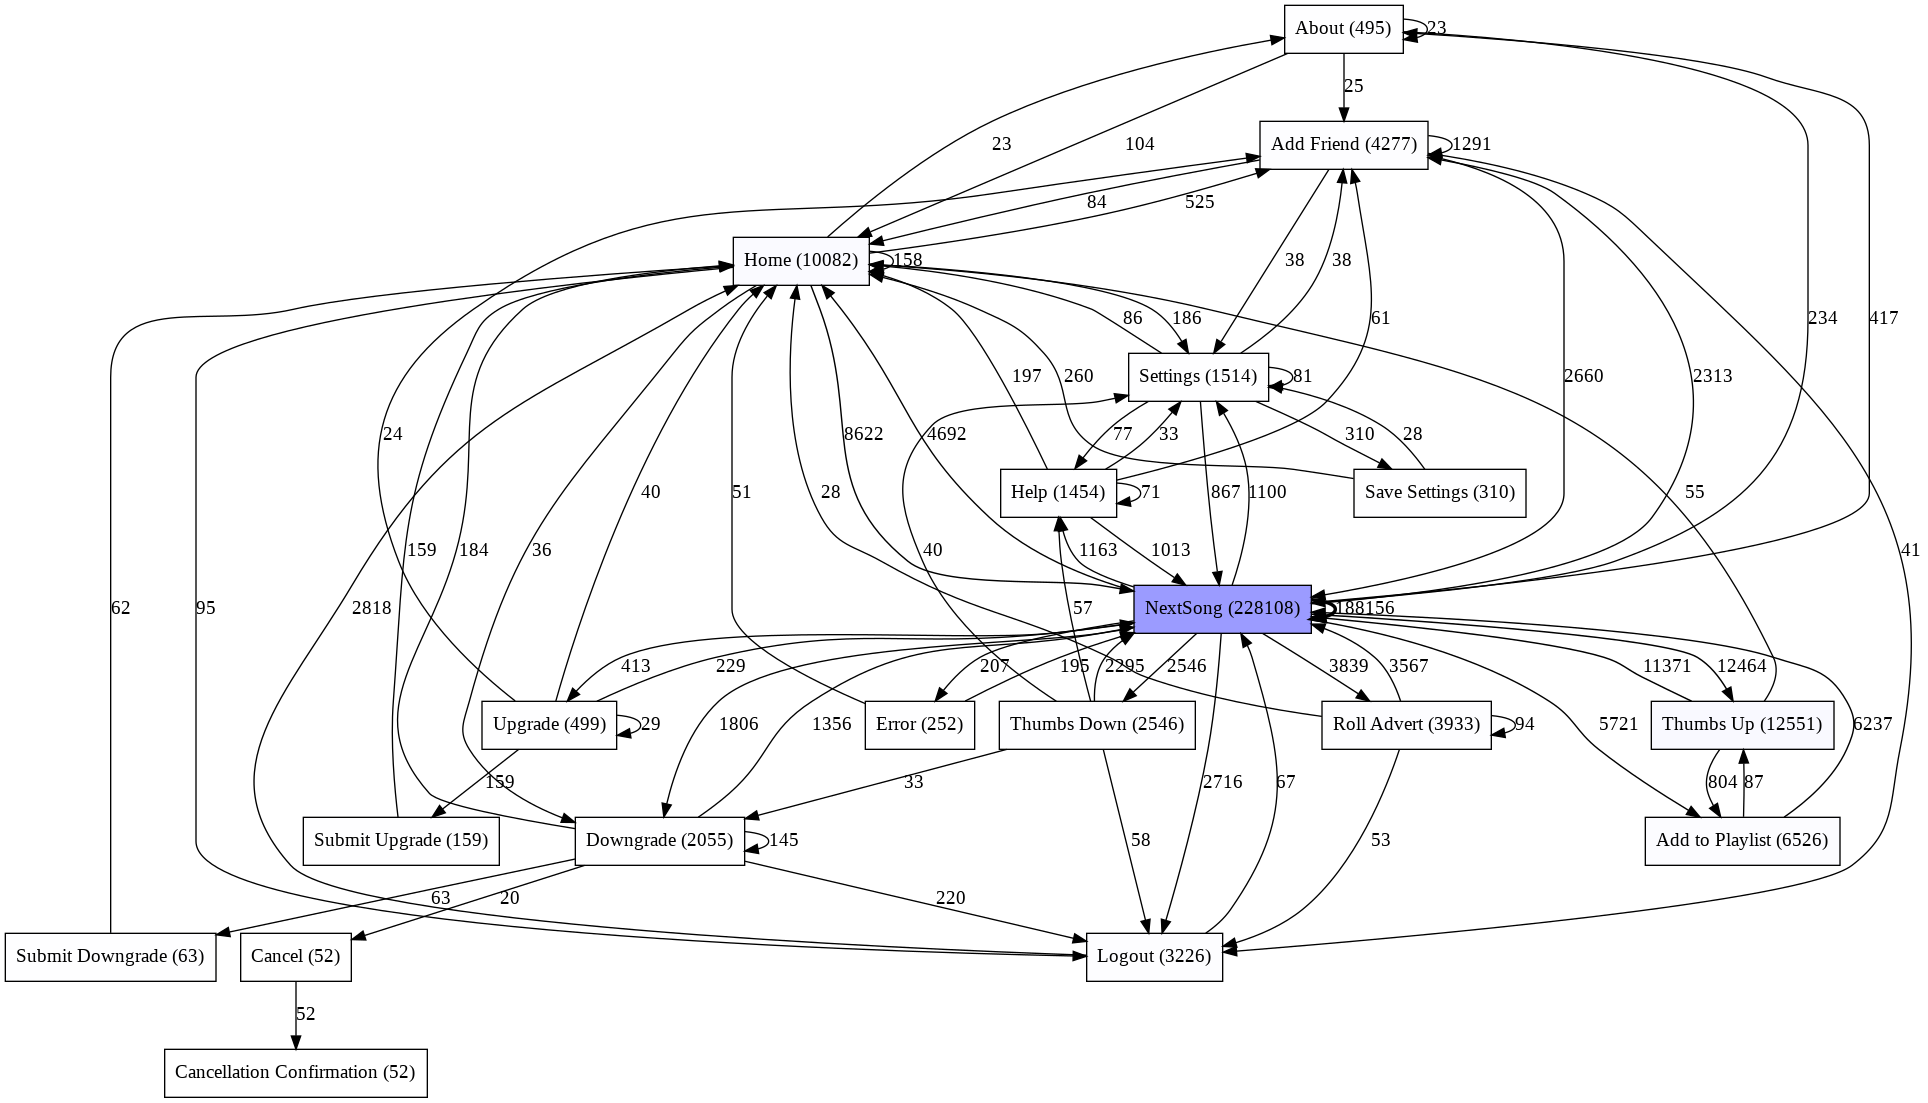

In [82]:
dfg = dfg_discovery.apply(event_log)
gviz = dfg_visualization.apply(dfg, log=event_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

In [0]:
net, im, fm = dfg_mining.apply(dfg)

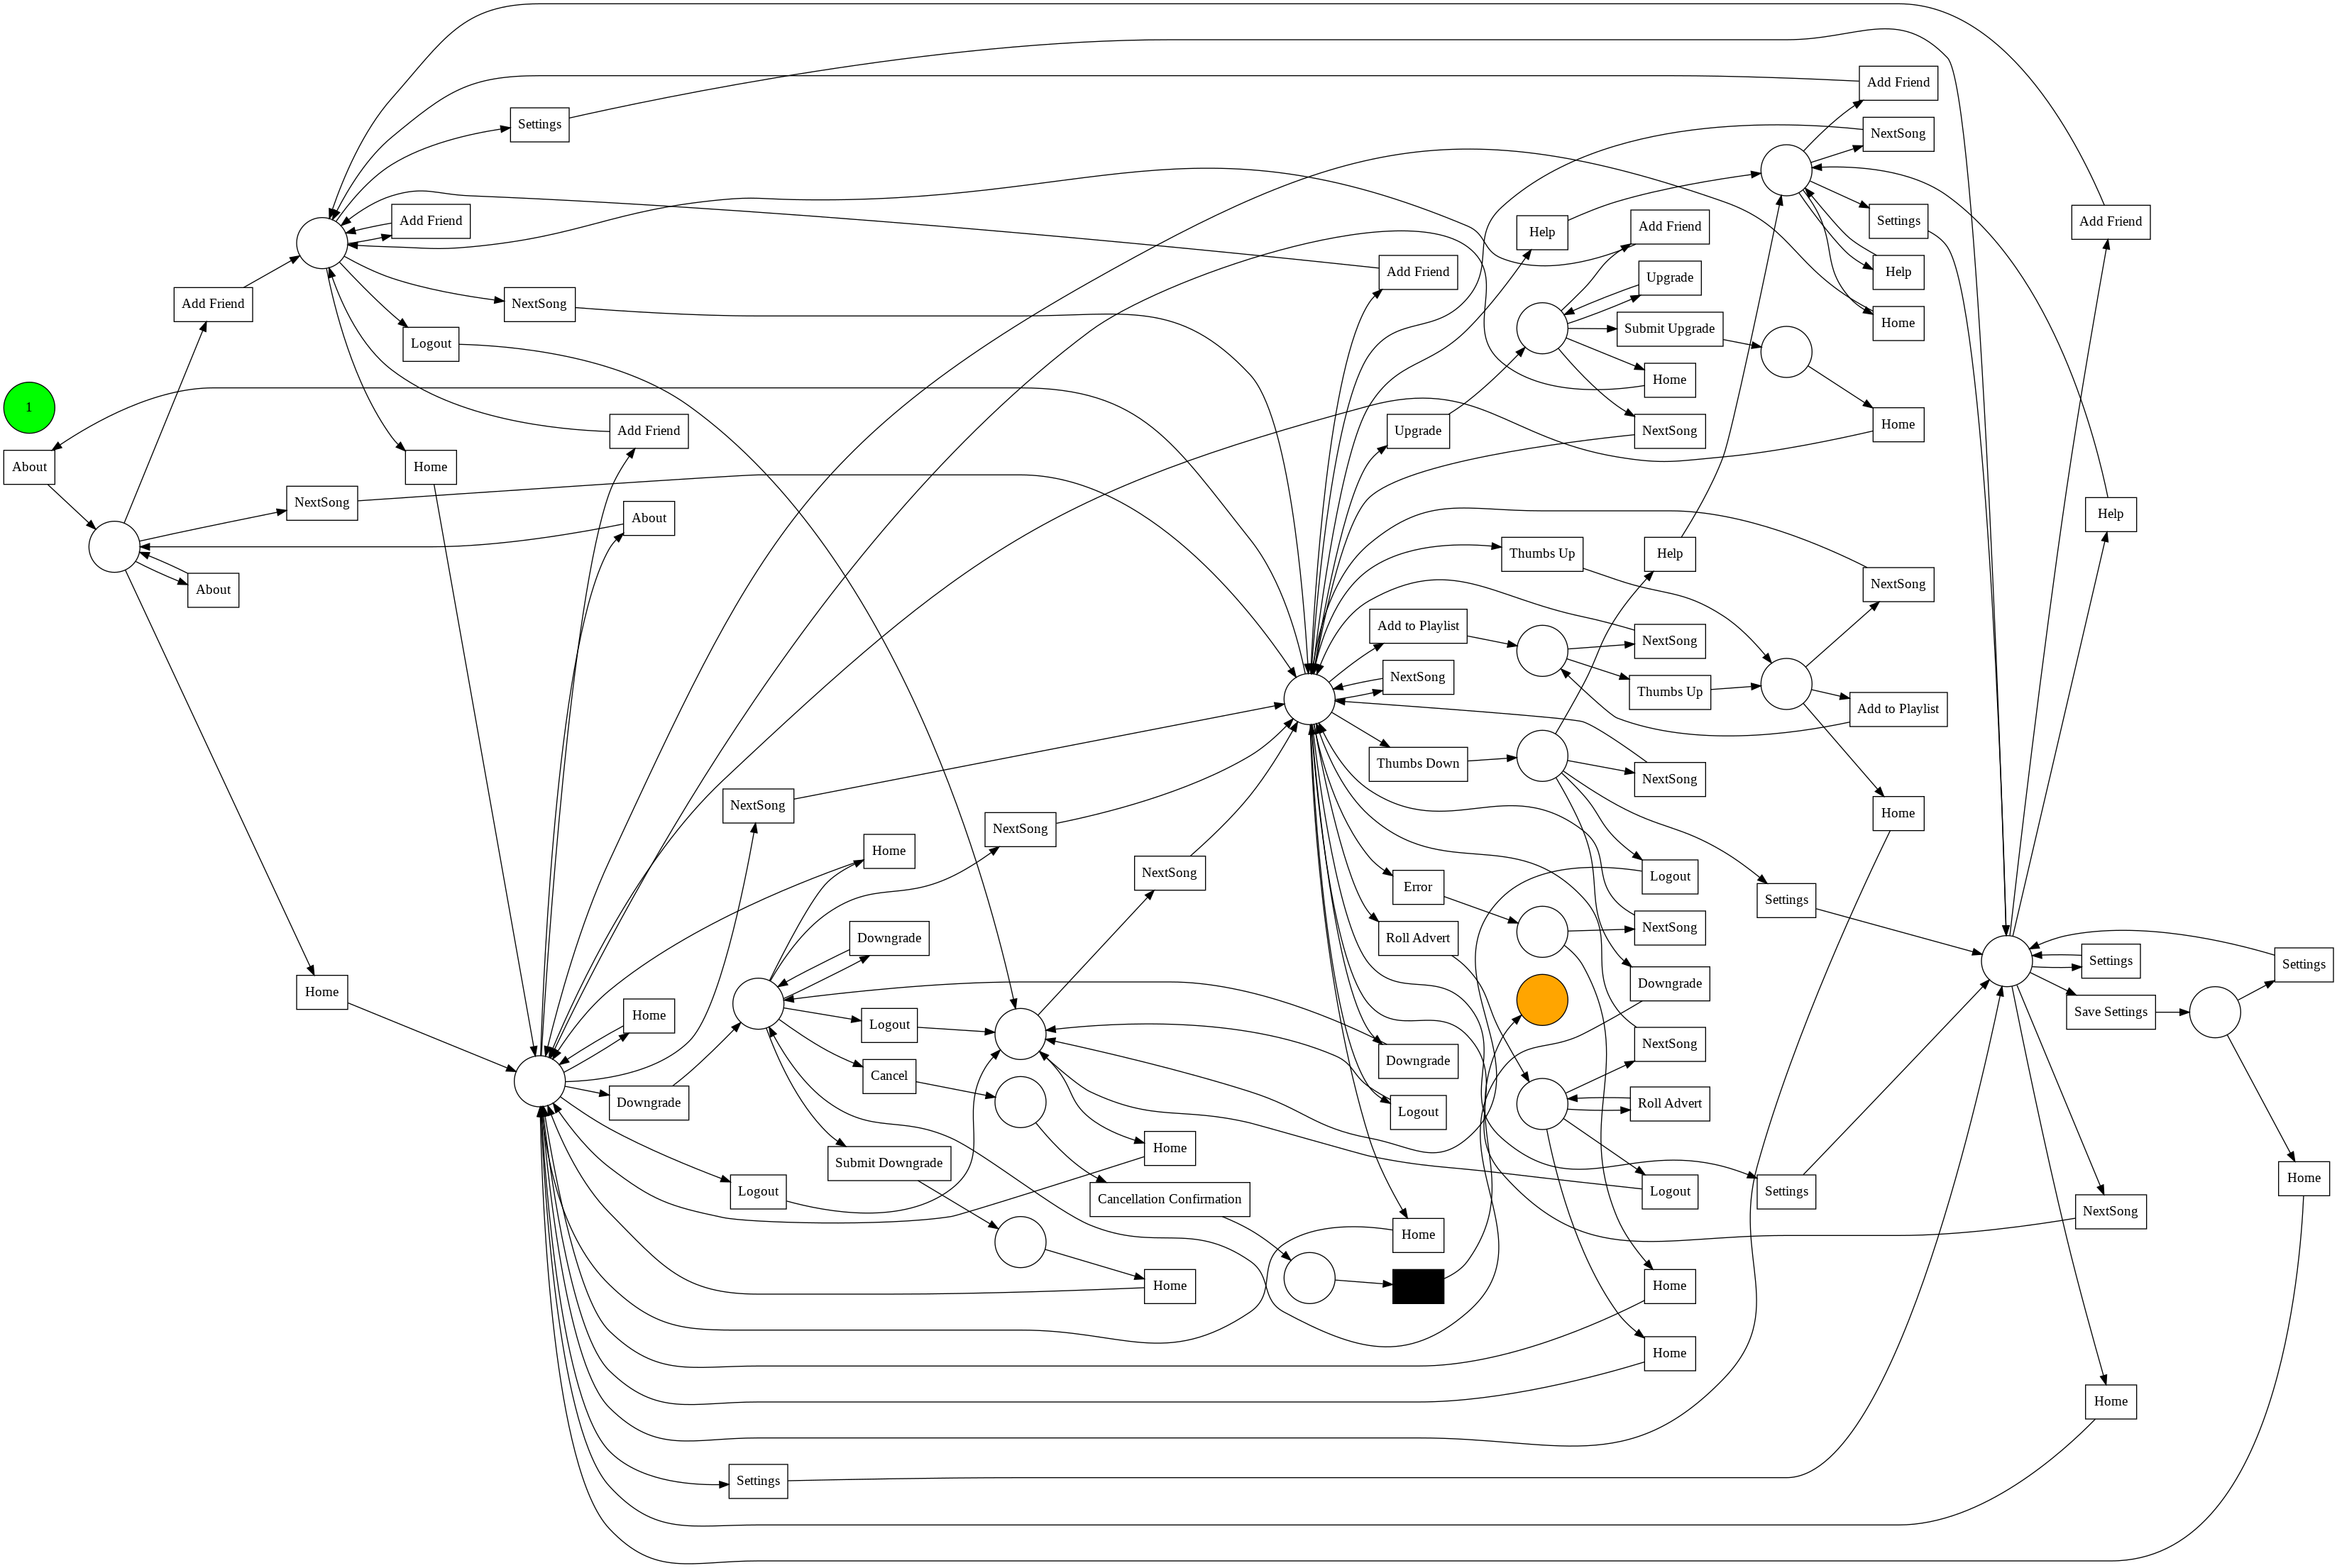

In [89]:
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)

### IMDFc (Inductive Miner Directly Follows)

http://www.processmining.org/_media/blogs/pub2015/bpmds_directly-follows_mining.pdf

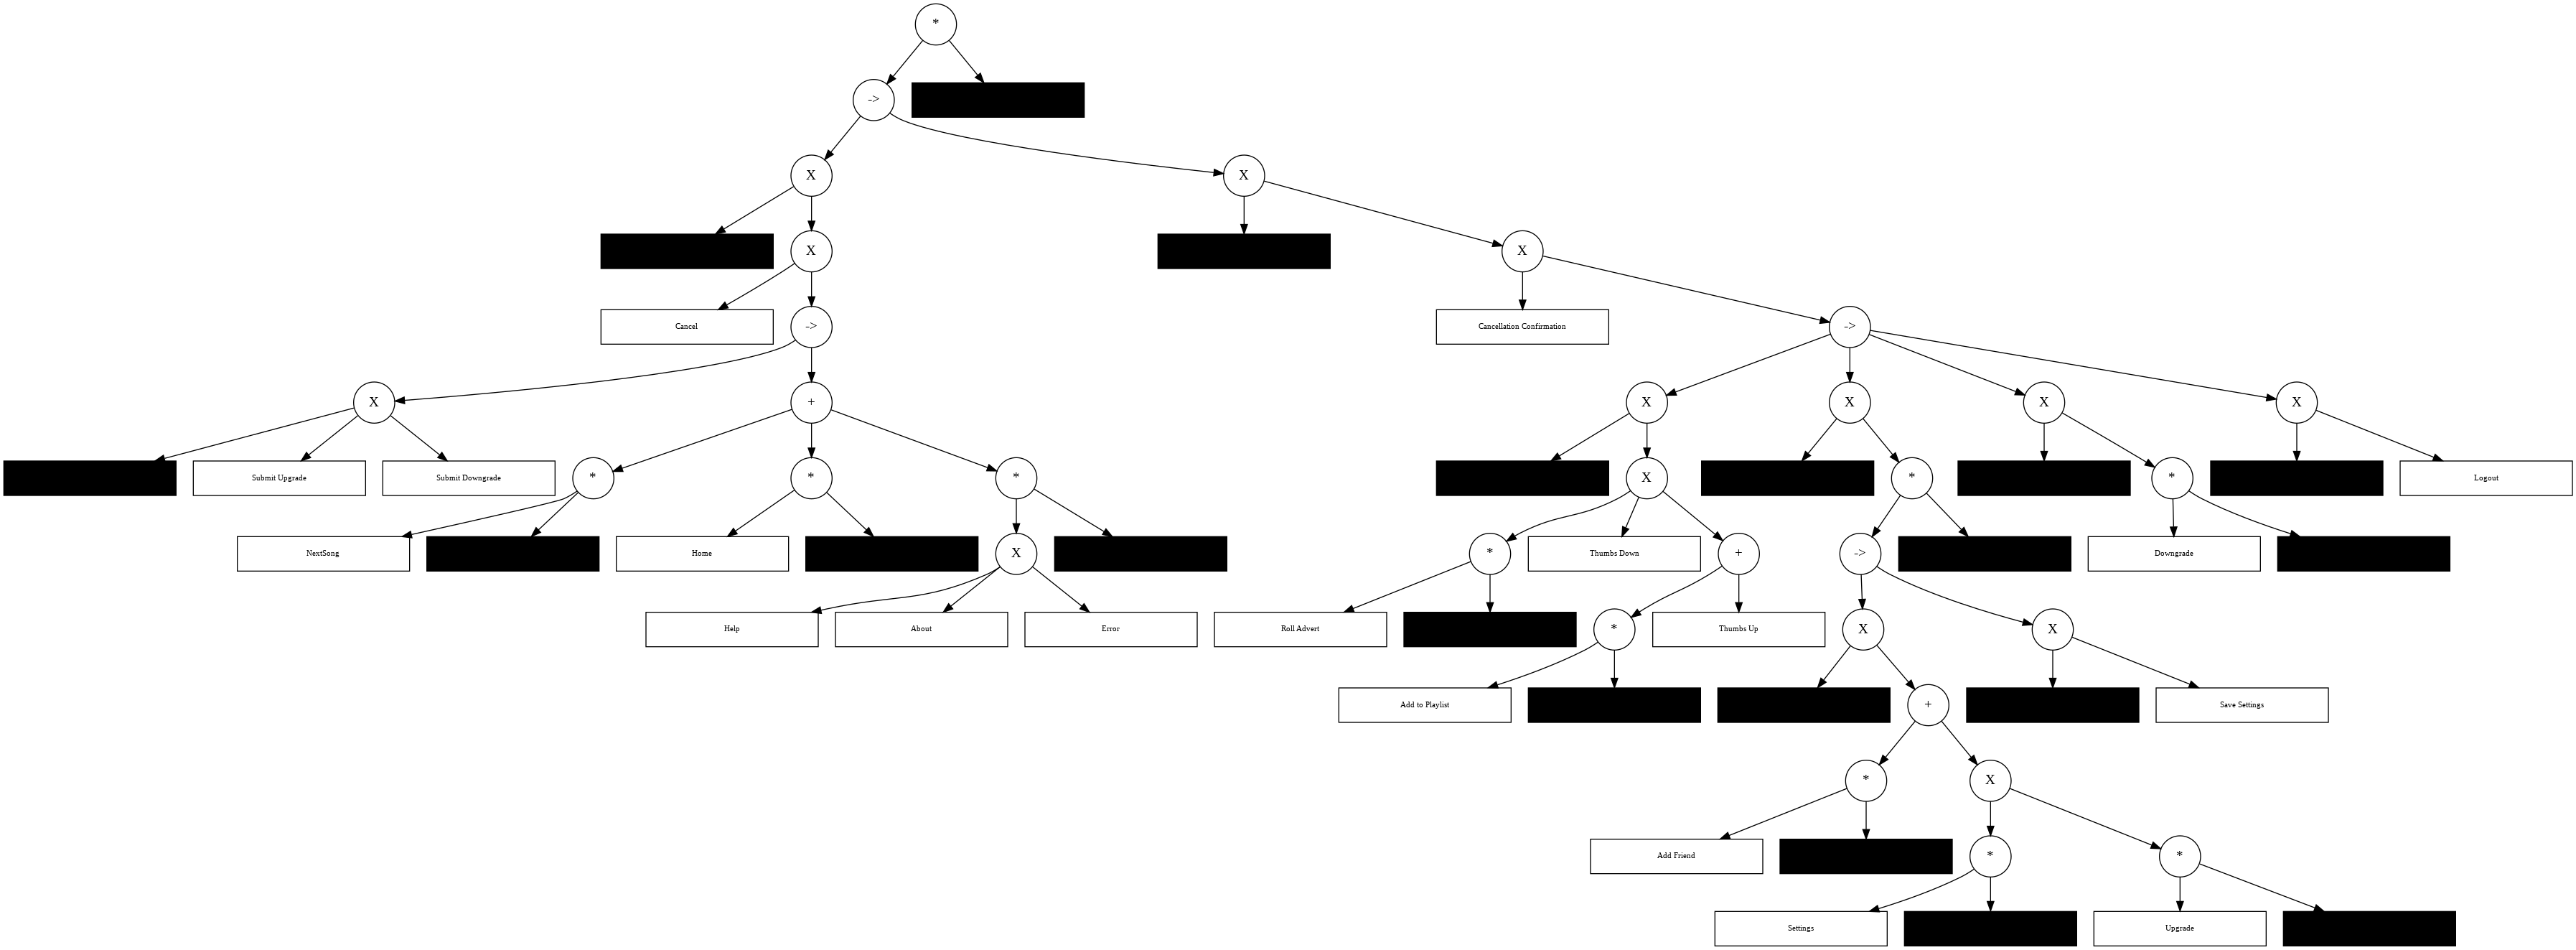

In [83]:
# generate Process tree
net, initial_marking, final_marking = inductive_miner.apply(event_log)
tree = inductive_miner.apply_tree(event_log)
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

Create a Petri net from tree and then visualize.

Wikipedia: A Petri net, also known as a place/transition (PT) net, is one of several mathematical modeling languages for the description of distributed systems. It is a class of discrete event dynamic system. A Petri net is a directed bipartite graph, in which the nodes represent transitions (i.e. events that may occur, represented by bars) and places (i.e. conditions, represented by circles). The directed arcs describe which places are pre- and/or postconditions for which transitions (signified by arrows). 

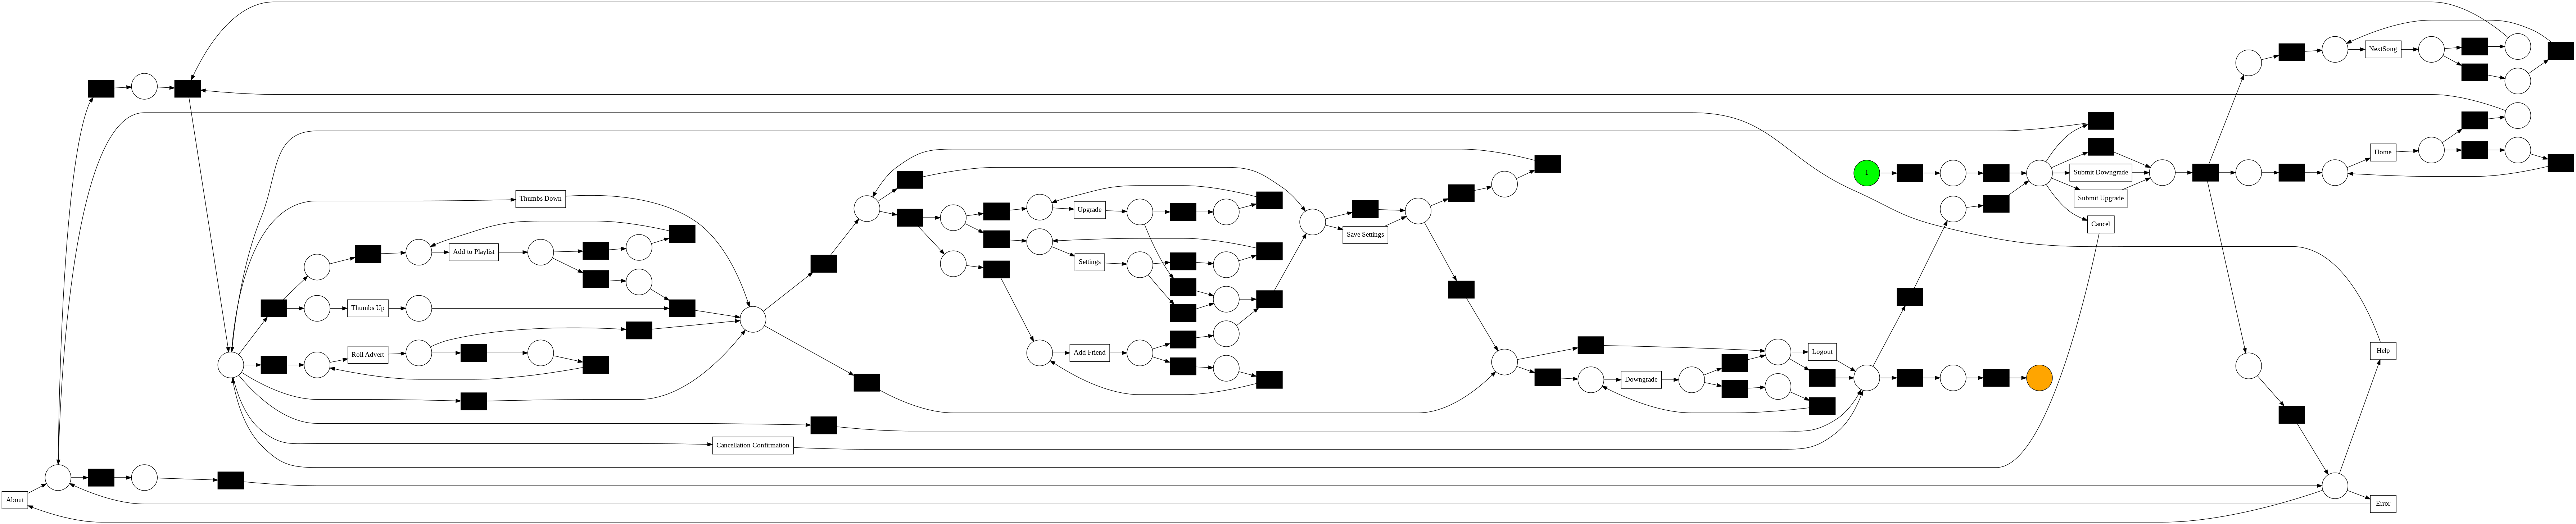

In [86]:
net, initial_marking, final_marking = pt_converter.apply(tree, variant=pt_converter.Variants.TO_PETRI_NET)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

### Heuristic Miner

This algorithm helps identify dependencies between activities and it's a good way to identify highly correlated features before running ML algorithms.

In [0]:
heu_net = heuristics_miner.apply_heu(event_log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})

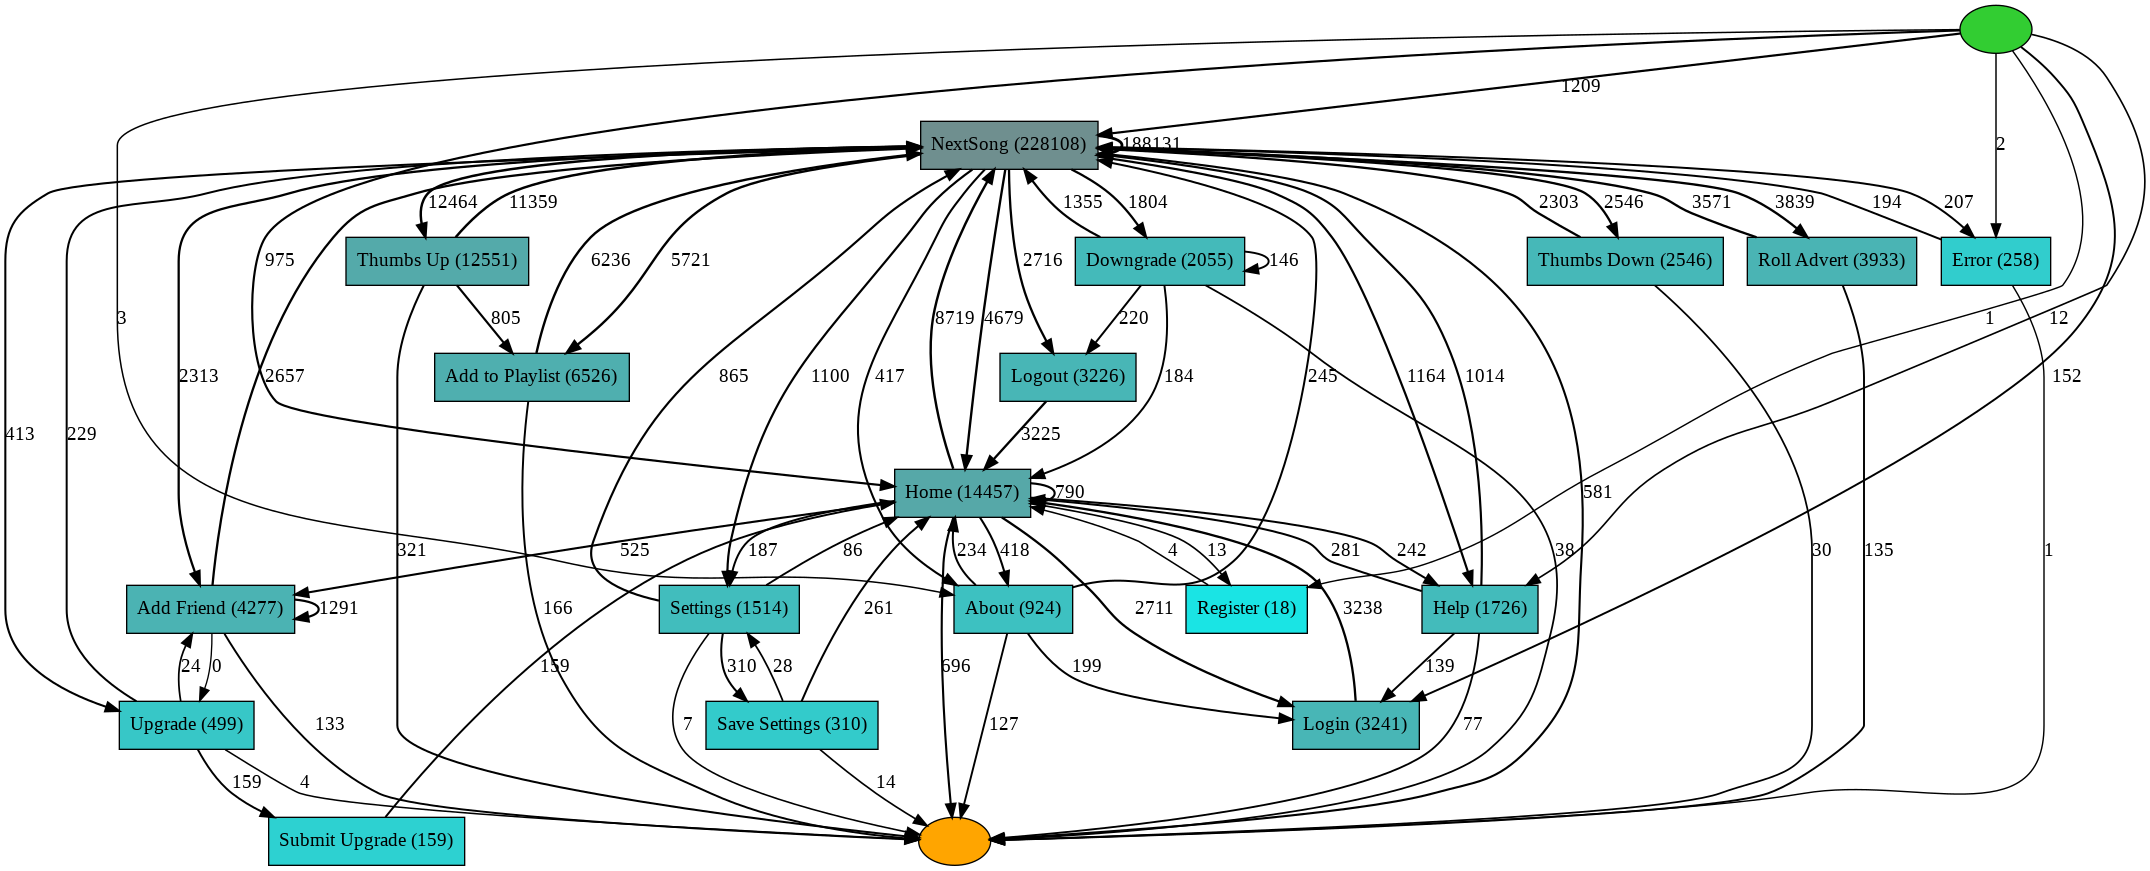

In [24]:
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

Visualize Petri Net using Heuristic Miner

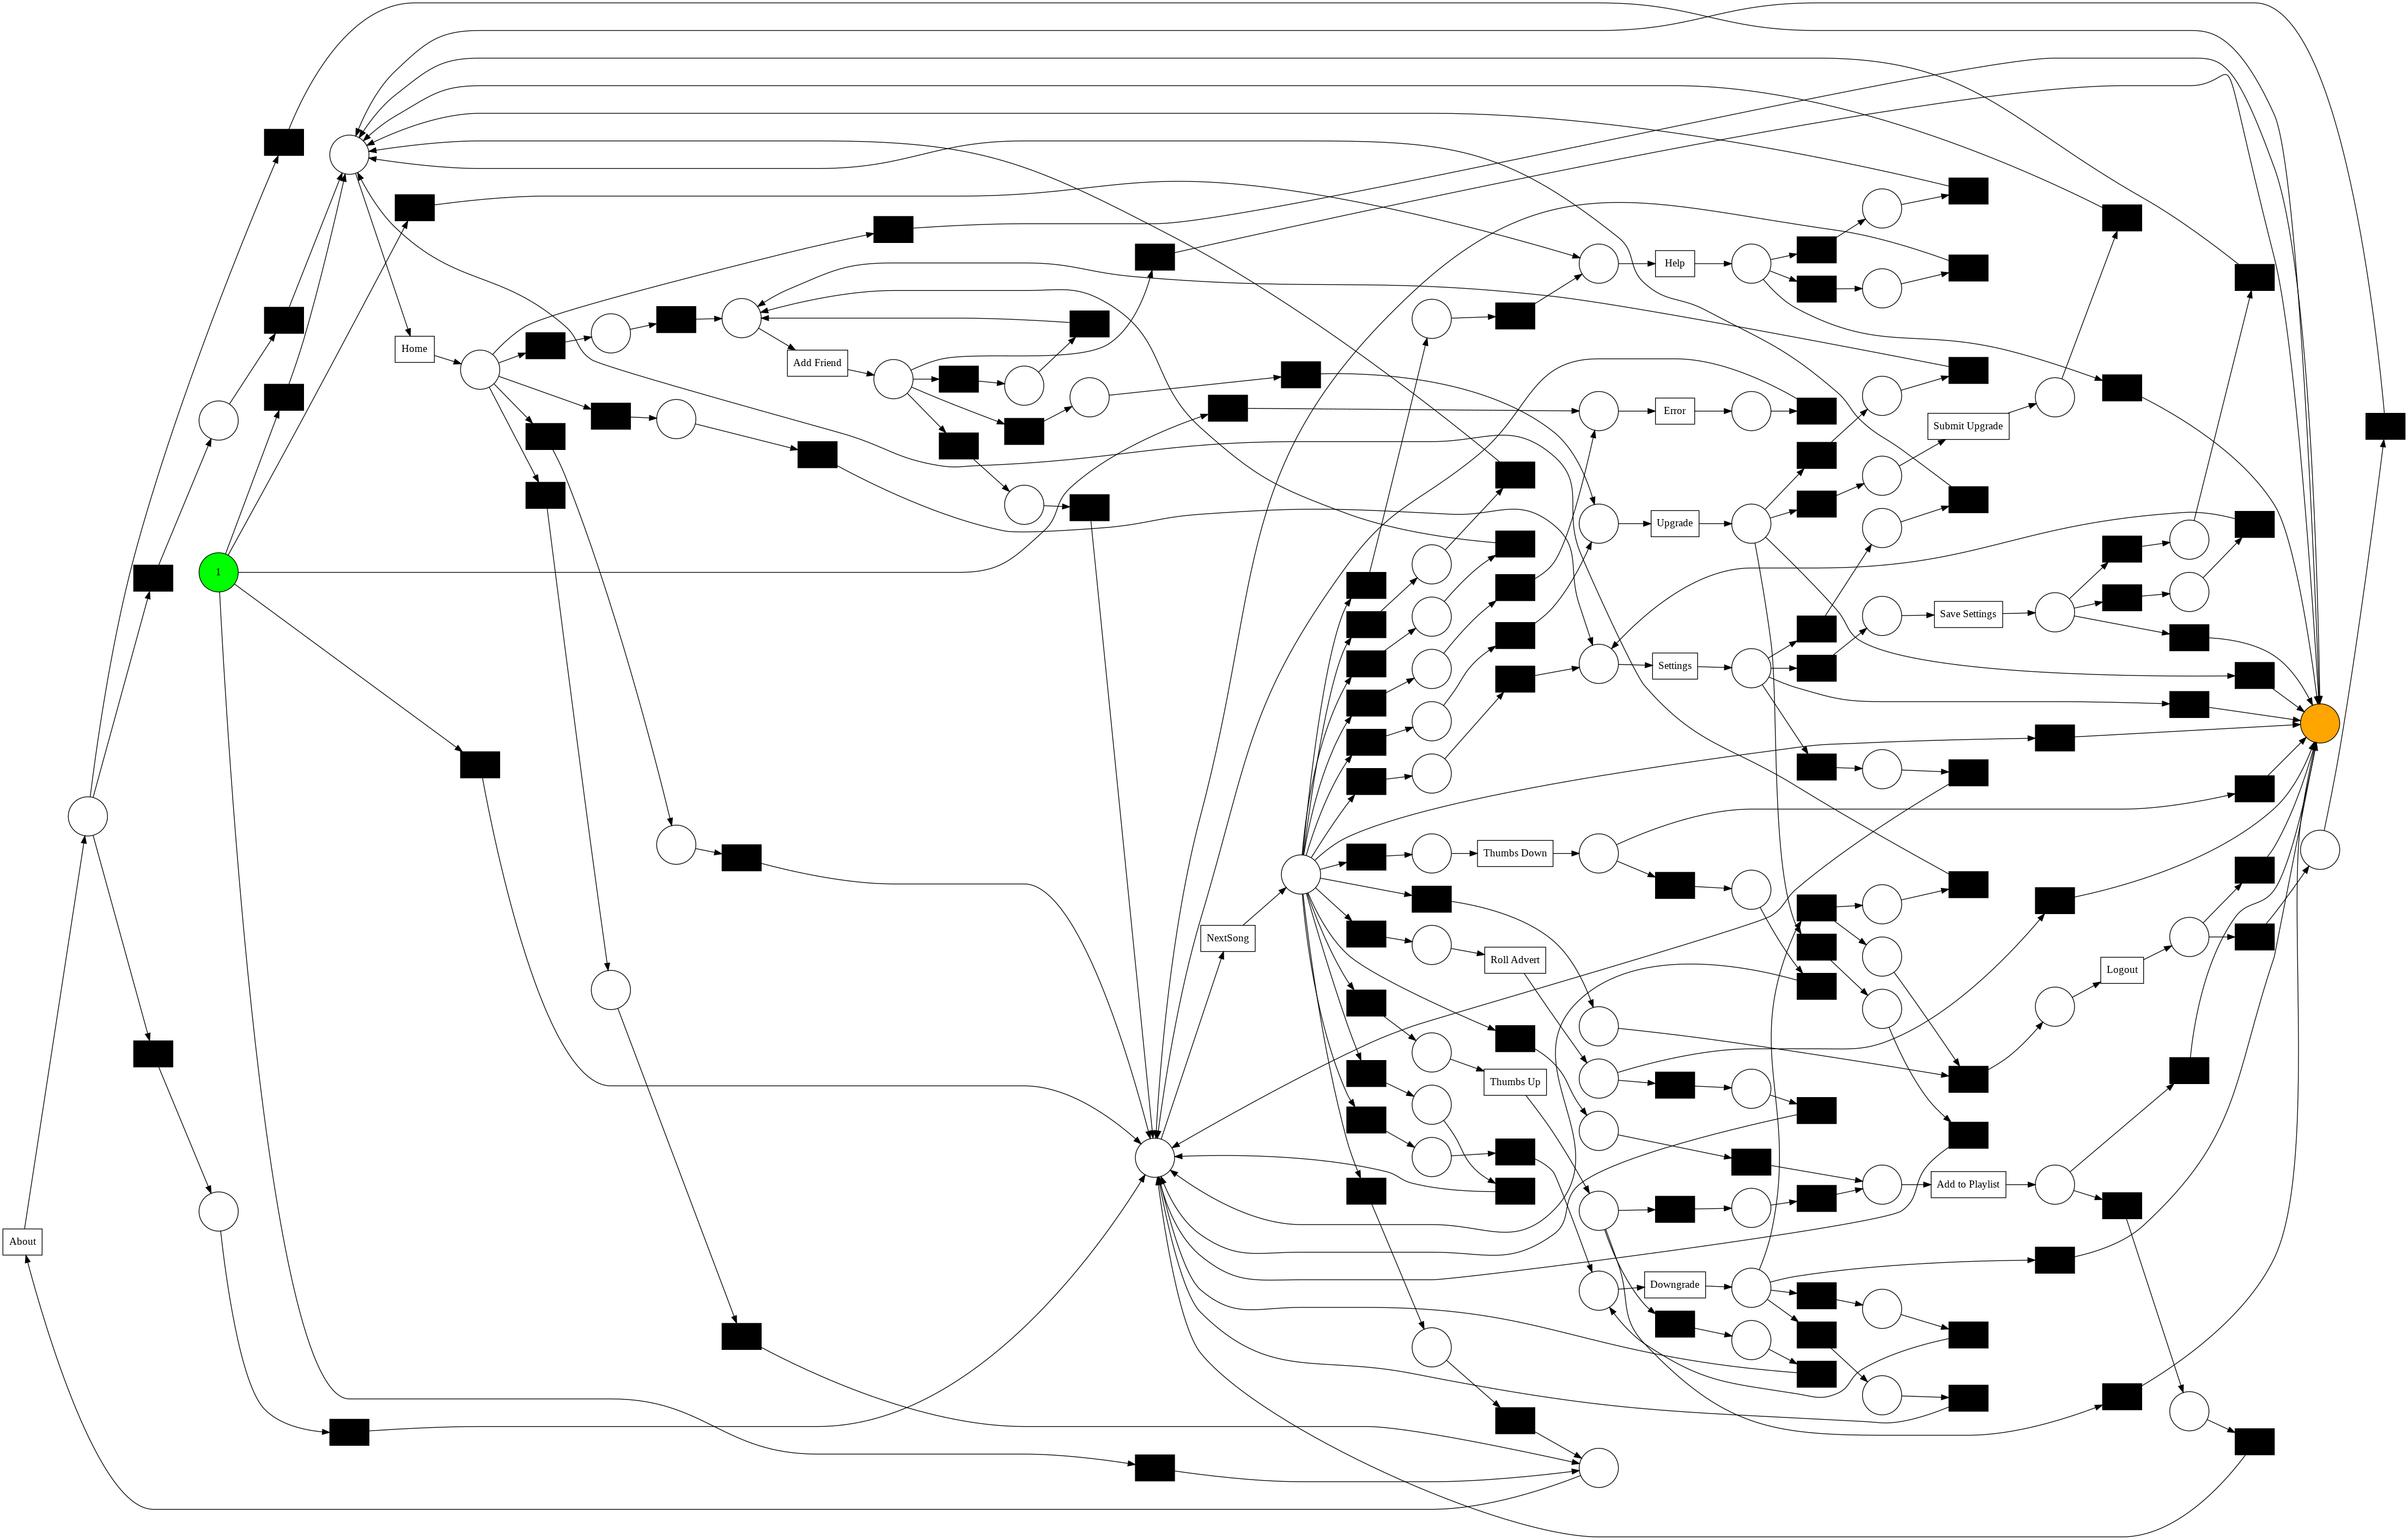

In [87]:
net, im, fm = heuristics_miner.apply(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)